In [185]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [186]:
df = pd.read_csv('pre_processed.csv')


In [78]:
# Drop rows with NaN values in categories column
df = df.dropna(subset=['categories'])

# Keep only rows where categories contain 'restaurants' or 'food'
df = df[df['categories'].str.contains('restaurants|food', case=False, regex=True)]

# Get the length of the resulting dataframe
length = len(df)

print(f"Length of dataset: {length}")

Length of dataset: 239065


In [9]:
# Select a random sample of 100 reviews
sub = df['text_processed'].sample(n=5000, random_state=42)

# Define function to get VADER sentiment scores
def get_vader_sentiment_scores(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(str(text))
    return scores['compound']



#Define function to get TextBlob sentiment polarity
def get_textblob_sentiment_polarity(text):
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    else:
        return 0.0

# Get VADER and TextBlob sentiment scores for Yelp review dataset
vader_sentiments = [get_vader_sentiment_scores(text) for text in sub]
textblob_sentiments = [get_textblob_sentiment_polarity(text) for text in sub]

# Convert sentiment scores to labels (positive, negative, neutral)
vader_sentiment_labels = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in vader_sentiments]
textblob_sentiment_labels = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in textblob_sentiments]

# Create a DataFrame to store the results
results = pd.DataFrame({'text': sub, 
                        'vader_sentiment': vader_sentiments, 
                        'vader_sentiment_label': vader_sentiment_labels,
                        'textblob_sentiment': textblob_sentiments, 
                        'textblob_sentiment_label': textblob_sentiment_labels})

# Add ground truth sentiment labels to Yelp review dataset
results['sentiment_label'] = results['vader_sentiment_label']

print(results.head())


                                                     text  vader_sentiment  \
270492  be to this place about three time over the pas...           0.9769   
87906   good food the red and green sauce rock the red...           0.8271   
273213  the good veggie sandwich I have ever eat the b...           0.9468   
10648   a one of a kind experience a sandbox for the k...           0.6083   
269386  priority be give to take out order so kitchen ...           0.2960   

       vader_sentiment_label  textblob_sentiment textblob_sentiment_label  \
270492              positive            0.335707                 positive   
87906               positive            0.205000                 positive   
273213              positive            0.850000                 positive   
10648               positive            0.132457                 positive   
269386              positive           -0.156944                 negative   

       sentiment_label  
270492        positive  
87906         posi

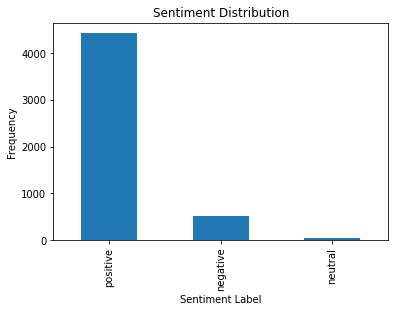

In [11]:
# Count the frequency of each sentiment label in the "sentiment_label" column
sentiment_counts = results["sentiment_label"].value_counts()

# Plot the sentiment distribution as a bar chart
sentiment_counts.plot(kind="bar")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Frequency")
plt.show()

In [12]:
grouped = results.groupby('sentiment_label')
sampled = grouped.apply(lambda x: x.sample(n=min(len(x), 50), random_state=42))
subset = sampled[['text', 'sentiment_label']]



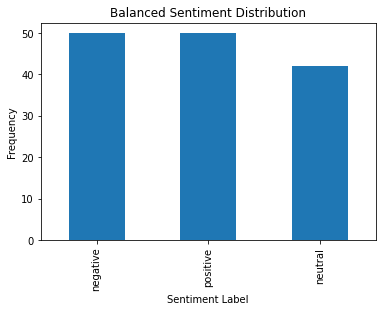

In [13]:
# Count the frequency of each sentiment label in the "sentiment_label" column of the subset DataFrame
sentiment_counts = subset["sentiment_label"].value_counts()

# Plot the balanced sentiment distribution as a bar chart
sentiment_counts.plot(kind="bar")
plt.title("Balanced Sentiment Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Frequency")
plt.show()


In [27]:
def calculate_metrics(sampled):
    """
    Calculate accuracy, F1 score, and recall for the sentiment analysis results.
    
    Args:
    results_df: Pandas DataFrame with columns 'vader_sentiment_label', 'textblob_sentiment_label', 
                and 'sentiment_label' (ground truth).
    
    Returns:
    A dictionary containing accuracy, F1 score, and recall for each sentiment analysis method.
    """
    vader_accuracy = accuracy_score(sampled['sentiment_label'], sampled['vader_sentiment_label'])
    textblob_accuracy = accuracy_score(sampled['sentiment_label'], sampled['textblob_sentiment_label'])

    vader_f1_score = f1_score(sampled['sentiment_label'], sampled['vader_sentiment_label'], average='weighted')
    textblob_f1_score = f1_score(sampled['sentiment_label'], sampled['textblob_sentiment_label'], average='weighted')

    vader_recall = recall_score(sampled['sentiment_label'], sampled['vader_sentiment_label'], average='weighted')
    textblob_recall = recall_score(sampled['sentiment_label'], sampled['textblob_sentiment_label'], average='weighted')

    metrics_dict = {'vader': {'accuracy': vader_accuracy, 'f1_score': vader_f1_score, 'recall': vader_recall},
                    'textblob': {'accuracy': textblob_accuracy, 'f1_score': textblob_f1_score, 'recall': textblob_recall}}

    return metrics_dict


In [40]:
vader_mean_sentiment = results['vader_sentiment'].mean()
textblob_mean_sentiment = results['textblob_sentiment'].mean()

print(f"VADER mean sentiment score: {vader_mean_sentiment}")
print(f"TextBlob mean sentiment score: {textblob_mean_sentiment}")


VADER mean sentiment score: 0.7046351582205677
TextBlob mean sentiment score: 0.26745004242550624


In [99]:
# Split the dataset into training and testing sets, ensuring that the classes are balanced
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])


In [100]:
# Train the sentiment analysis models
vader_analyzer = SentimentIntensityAnalyzer()

In [101]:
train_df['text_processed'].isna().sum()

0

In [102]:
# Add a 'vader_sentiment' column to the training set
train_df['vader_sentiment'] = train_df['text_processed'].apply(lambda x: 'positive' if vader_analyzer.polarity_scores(x)['compound'] >= 0 else 'negative')

# Add a 'textblob_sentiment' column to the training set
train_df['textblob_sentiment'] = train_df['text_processed'].apply(lambda x: 'positive' if TextBlob(x).sentiment[0] >= 0 else 'negative')



In [105]:
y_true_v = testing_set['sentiment'].values
#y_true_t = testing_set['textblob_sentiment'].values

vader_preds = testing_set['text_processed'].apply(lambda x: 'positive' if vader_analyzer.polarity_scores(x)['compound'] >= 0 else 'negative').values
textblob_preds = testing_set['text_processed'].apply(lambda x: 'positive' if TextBlob(x).sentiment[0] >= 0 else 'negative').values

In [106]:
vader_preds

array(['positive', 'positive', 'positive', ..., 'positive', 'negative',
       'positive'], dtype=object)

In [111]:
# Calculate accuracy for Vader and TextBlob
vader_accuracy = accuracy_score(y_true_v, vader_preds)
textblob_accuracy = accuracy_score(y_true_v, textblob_preds)

In [61]:
# Train the sentiment analysis models
vader_analyzer = SentimentIntensityAnalyzer()

# Predict the sentiment using VADER and TextBlob
vader_preds = test_df['text_processed'].apply(lambda x: 'positive' if vader_analyzer.polarity_scores(x)['compound'] >= 0 else 'negative').values
textblob_preds = test_df['text_processed'].apply(lambda x: 'positive' if TextBlob(x).sentiment[0] >= 0 else 'negative').values

# Calculate accuracy scores for sentiment and textblob_sentiment columns separately
vader_accuracy = accuracy_score(test_df['sentiment'].values, vader_preds)
textblob_accuracy = accuracy_score(test_df['textblob_sentiment'].values, textblob_preds)

# Calculate F1 scores for sentiment and textblob_sentiment columns separately
vader_f1 = f1_score(test_df['sentiment'].values, vader_preds, pos_label='positive')
textblob_f1 = f1_score(test_df['textblob_sentiment'].values, textblob_preds, pos_label='positive')

# Calculate recall scores for sentiment and textblob_sentiment columns separately
vader_recall = recall_score(test_df['sentiment'].values, vader_preds, pos_label='positive')
textblob_recall = recall_score(test_df['textblob_sentiment'].values, textblob_preds, pos_label='positive')


In [65]:
class TextBlobTransformer:
    def transform(self, X):
        return [TextBlob(text) for text in X]

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X)

In [67]:
from sklearn.model_selection import cross_validate, KFold

In [80]:
# Extract the review text and star rating columns
reviews = df['text']
ratings = df['stars_x']

In [81]:
def label_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

In [82]:
sentiments = ratings.map(label_sentiment)

In [84]:
df['sentiment'] = df['stars_x'].map(label_sentiment)

In [175]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

vader_analyzer = SentimentIntensityAnalyzer()

# Add a 'vader_sentiment' column to the training set
train_df['vader_sentiment'] = train_df['text_processed'].apply(lambda x: 'positive' if vader_analyzer.polarity_scores(x)['compound'] >= 0 else 'negative')

# Add a 'textblob_sentiment' column to the training set
train_df['textblob_sentiment'] = train_df['text_processed'].apply(lambda x: 'positive' if TextBlob(x).sentiment[0] >= 0 else 'negative')

y_true_v = test_df['sentiment'].values
#y_true_t = test_df['textblob_sentiment'].values

vader_preds = test_df['text_processed'].apply(lambda x: 'positive' if vader_analyzer.polarity_scores(x)['compound'] >= 0 else 'negative').values
textblob_preds = test_df['text_processed'].apply(lambda x: 'positive' if TextBlob(x).sentiment[0] >= 0 else 'negative').values

# Calculate accuracy for Vader and TextBlob
vader_accuracy = accuracy_score(y_true_v, vader_preds)
textblob_accuracy = accuracy_score(y_true_v, textblob_preds)


In [176]:
# Calculate accuracy, F1 score and recall for Vader
vader_accuracy = accuracy_score(y_true_v, vader_preds)
vader_f1 = f1_score(y_true_v, vader_preds, average='weighted')
vader_recall = recall_score(y_true_v, vader_preds,average='weighted')

# Calculate accuracy, F1 score and recall for TextBlob
textblob_accuracy = accuracy_score(y_true_v, textblob_preds)
textblob_f1 = f1_score(y_true_v, textblob_preds, average='weighted')
textblob_recall = recall_score(y_true_v, textblob_preds, average='weighted')



In [179]:
# Calculate precision for Vader
vader_precision = precision_score(y_true_v, vader_preds, average='weighted')

# Calculate precision for TextBlob
textblob_precision = precision_score(y_true_v, textblob_preds, average='weighted')

print('Vader precision:', vader_precision)
print('TextBlob precision:', textblob_precision)


Vader precision: 0.5458962811303223
TextBlob precision: 0.5468200304049291


D:\python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [181]:
print('Vader scores:')
print('Accuracy:', round(vader_accuracy, 4))
print('F1 score:', round(vader_f1, 4))
print('Recall:', round(vader_recall, 4))
print('Precision:', round(vader_precision,4))

print('\nTextBlob scores:')
print('Accuracy:', round(textblob_accuracy, 4))
print('F1 score:', round(textblob_f1, 4))
print('Recall:', round(textblob_recall, 4))
print('Precision:', round(textblob_precision,4))

Vader scores:
Accuracy: 0.6782
F1 score: 0.6035
Recall: 0.6782
Precision: 0.5459

TextBlob scores:
Accuracy: 0.6808
F1 score: 0.6051
Recall: 0.6808
Precision: 0.5468
